In [1]:
# Imports
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import access_api as api
from datetime import datetime, timedelta

#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

2021-11-14 16:49:21.069772: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-14 16:49:21.069792: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def create_prediction_date_range(dates):
    # Check if any of the dates is before the last date the model was trained on. If yes, exclude it
    
    # Check if any of the dates is a trading day. If yes, exlude it
    
    
    
    # Determine prediction period
    us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
    n_past = 1
    dates_to_predict = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()

In [3]:
def prepare_data(df, target_var):
    train_dates = pd.to_datetime(df['Date'])
    #Separate dates for future plotting
    # train_dates = pd.to_datetime(df['Date'])
    #Variables for training
    cols = list(df)
    print(cols)
    cols.remove("Date")
    #Date and volume columns are not used in training. 
    print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

    #New dataframe with only training data - 5 columns
    df_for_training = df[cols].astype(float)
    
    # Find out the index of the variable which should be predicted
    target_var_x_index = list(df_for_training).index(target_var)
    target_var_x_index
    
    # normalize the dataset
    scaler = StandardScaler()
    scaler = scaler.fit(df_for_training)
    df_for_training_scaled = scaler.transform(df_for_training)
    
    #As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
    #In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

    #Empty lists to be populated using formatted training data
    trainX = []
    trainY = []

    n_future = 1   # Number of days we want to look into the future based on the past days.
    n_past = 60  # Number of past days we want to use to predict the future.

    #Reformat input data into a shape: (n_samples x timesteps x n_features)
    #In my example, my df_for_training_scaled has a shape (12823, 5)
    #12823 refers to the number of data points and 5 refers to the columns (multi-variables).
    for i in range(n_past, len(df_for_training_scaled) - n_future +1):
        # trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
        # trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])
        trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
        trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, target_var_x_index])


    trainX, trainY = np.array(trainX), np.array(trainY)

    print('trainX shape == {}.'.format(trainX.shape))
    print('trainY shape == {}.'.format(trainY.shape))
    scaler_input_shape = df_for_training.shape[1]
    return trainX, trainY, scaler, scaler_input_shape, train_dates

In [4]:
def create_model(input_shape, output_shape):
    # define the Autoencoder model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(input_shape[1], input_shape[2]), return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(output_shape[1]))

    model.compile(optimizer='adam', loss='mse')
    return model

In [5]:
def evaluate_model(history):
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()

In [6]:
def model_workflow(df, target_var, n_days_for_prediction=21, plot_performance = True):
    trainX, trainY, scaler, scaler_input_shape, train_dates = prepare_data(df, target_var)
    model = create_model(trainX.shape, trainY.shape)
    model.summary()

    # fit the model
    history = model.fit(trainX, trainY, epochs=25, batch_size=16, validation_split=0.1, verbose=1)

    if plot_performance:
        evaluate_model(history)

    # Determine prediction period
    us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
    n_past = 1
    dates_to_predict = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()

    #Make prediction
    prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

    #Perform inverse transformation to rescale back to original range
    #Since we used 5 variables for transform, the inverse expects same dimensions
    #Therefore, let us copy our values 5 times and discard them after inverse transform
    prediction_copies = np.repeat(prediction, scaler_input_shape, axis=-1)
    y_pred_future = scaler.inverse_transform(prediction_copies)[:,target_var_x_index]

    # Convert timestamp to date
    forecast_dates = []
    for time_i in dates_to_predict:
        forecast_dates.append(time_i.date())
    df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), target_var :y_pred_future})
    df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

    original = df[['Date', target_var]].copy()
    original['Date'] = pd.to_datetime(original['Date'])
    original = original.loc[original['Date'] >= '2021-5-1']

    # Store the data in one dataset so that we can plot a continuous line
    combined_dfs = original.append(df_forecast)
    last_date_from_data = original["Date"][original.index[-1]]
    
    fig, axes = plt.subplots(figsize=(20,7))
    plt.axvline(last_date_from_data, color = "r")
    sns.lineplot(x = combined_dfs["Date"], y = combined_dfs[target_var], label = target_var + ' price')

In [7]:
tickers = ["BTC-USD", "AAPL", "GOOG", "GC=F"]
start_date = datetime(year = 2019, month = 11, day = 10)
end_date = datetime(year = 2021, month = 11, day = 10)
df = api.get_adj_close_df(tickers, start_date, end_date)
df = df.dropna()
df["Date"] = df.index
df.index = range(1, df.shape[0] + 1)
df.head()

,GOOG,BTC-USD,GC=F,AAPL,Date
1,1299.189941,8757.788086,1455.500000,64.590576,2019-11-11
2,1298.800049,8815.662109,1452.099976,64.531441,2019-11-12
3,1298.000000,8808.262695,1461.699951,65.149773,2019-11-13
4,1311.459961,8708.094727,1471.800049,64.698967,2019-11-14
5,1334.869995,8491.992188,1467.300049,65.467537,2019-11-15


['GOOG', 'BTC-USD', 'GC=F', 'AAPL', 'Date']
['GOOG', 'BTC-USD', 'GC=F', 'AAPL']
trainX shape == (437, 60, 4).
trainY shape == (437, 1).


2021-11-14 16:49:27.284241: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-14 16:49:27.284263: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-14 16:49:27.284280: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (martin-ThinkPad-T490): /proc/driver/nvidia/version does not exist
2021-11-14 16:49:27.284478: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 64)            17664     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25


2021-11-14 16:49:27.538877: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


25/25 [==============================] - 2s 37ms/step - loss: 0.3810 - val_loss: 0.0692
Epoch 2/25
25/25 [==============================] - 1s 26ms/step - loss: 0.1579 - val_loss: 0.2149
Epoch 3/25
25/25 [==============================] - 1s 26ms/step - loss: 0.0835 - val_loss: 0.1984
Epoch 4/25
25/25 [==============================] - 1s 30ms/step - loss: 0.0768 - val_loss: 0.0301
Epoch 5/25
25/25 [==============================] - 1s 28ms/step - loss: 0.0586 - val_loss: 0.0331
Epoch 6/25
25/25 [==============================] - 1s 27ms/step - loss: 0.0633 - val_loss: 0.0372
Epoch 7/25
25/25 [==============================] - 1s 25ms/step - loss: 0.0599 - val_loss: 0.0683
Epoch 8/25
25/25 [==============================] - 1s 28ms/step - loss: 0.0494 - val_loss: 0.0320
Epoch 9/25
25/25 [==============================] - 1s 27ms/step - loss: 0.0475 - val_loss: 0.0432
Epoch 10/25
25/25 [==============================] - 1s 26ms/step - loss: 0.0487 - val_loss: 0.0560
Epoch 11/25
25/25 [=

NameError: name 'target_var_x_index' is not defined

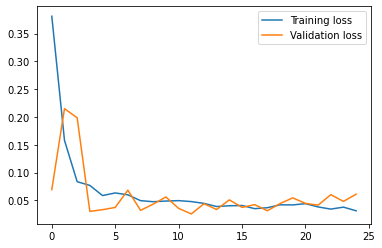

In [8]:
model_workflow(df, target_var = "AAPL")

In [ ]:
ticker = "AAPL"
start_date = datetime(year = 2019, month = 11, day = 10)
end_date = datetime(year = 2021, month = 11, day = 10)
df_AAPL = api.get_stock_data(ticker, start_date, end_date)
df_AAPL = df_AAPL.dropna()
df_AAPL["Date"] = df_AAPL.index
df_AAPL.index = range(1, df_AAPL.shape[0] + 1)
model_workflow(df_AAPL, target_var = "Adj Close" )